In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
import yfinance as yf 
from datetime import datetime, timedelta

In [62]:
class FinancialData():

    def __init__(self, tickers_csv_path, num_tickers):
        self.tickers_csv_path = tickers_csv_path
        self.num_tickers = num_tickers
        self.tickers = None
        self.data_clean = None
        self.mu = None
        self.Sigma = None

    def extract_tickers(self):
        tickers_df = pd.read_csv(self.tickers_csv_path)
        list_tickers = tickers_df.loc[:self.num_tickers - 1, 'Ticker'].tolist()
        self.tickers = list_tickers
    
    def get_returns(self, start, end, period="1d"):
        data = yf.download(self.tickers, start=start, end=end, period=period)['Adj Close']
        data = data.pct_change(fill_method=None).dropna()
        data.index = data.index.strftime("%Y-%m-%d")
        self.data_clean = data

    def calculate_statistics(self):
        if self.data_clean is not None:
            self.mu = self.data_clean.mean(axis=0).values
            self.Sigma = self.data_clean.cov().to_numpy()
        else:
            print("get returns before please")


In [63]:
# input 

tickers_csv_path = "C:\\Users\\Nicola\\clones_github\\DL-Portfolio-CMAP\\data\\S&P 500 tickers.csv"
num_tickers = 5 
end = datetime.today()
start = end - timedelta(days=365.25*20)

In [64]:
# output

data_extractor_5 = FinancialData(tickers_csv_path, num_tickers)
data_extractor_5.extract_tickers()
data_extractor_5.get_returns(start=start, end=end)
data_extractor_5.calculate_statistics()
rets_df = data_extractor_5.data_clean
mu_5 = data_extractor_5.mu
Sigma_5 = data_extractor_5.Sigma

rets_df.head()

[*********************100%***********************]  5 of 5 completed


Ticker,ABBV,ABT,ACN,AOS,MMM
Date,,,,,
2013-01-03,-0.008257,0.038066,-0.003620,-0.015632,-0.001161
2013-01-04,-0.012633,-0.006012,0.005523,0.010849,0.007394
2013-01-07,0.002036,0.008165,-0.004336,-0.011044,0.001258
2013-01-08,-0.021764,0.000300,0.005806,0.019031,0.000105
2013-01-09,0.005636,0.006597,0.007072,-0.006483,0.009529


In [69]:
# envisager de coder un truc qui gere des lambdas de plusieurs tailles 

def get_markowitz_weights(lam, mu, Sigma):
    Sigma_inv = np.linalg.inv(Sigma)
    n = len(mu)
    e = np.ones(n)

    eT_Sigma_inv_e = e.T @ Sigma_inv @ e
    eT_Sigma_inv_mu = e.T @ Sigma_inv @ mu

    term1 = Sigma_inv @ e / eT_Sigma_inv_e
    
    adjusted_mu = Sigma_inv @ mu - (eT_Sigma_inv_mu / eT_Sigma_inv_e) * (Sigma_inv @ e)
    term2 = (1 / lam) * adjusted_mu
    w_star = term1 + term2
    return w_star

array([ 2.49717095, -1.21486763,  1.99239314,  1.66829656, -3.94299302])

In [89]:
lambdas = np.linspace(0.001, 50, 100)
weights = np.array(list(map(lambda lam: get_markowitz_weights(lam, mu_5, Sigma_5), lambdas)))

In [90]:
mus = []
vols = []

for weight in weights:
    mu_port = weight.T @ mu_5
    sigma_port = weight.T @ Sigma_5 @ weight
    mus.append(mu_port)
    vols.append(np.sqrt(sigma_port))

Text(0, 0.5, 'mean')

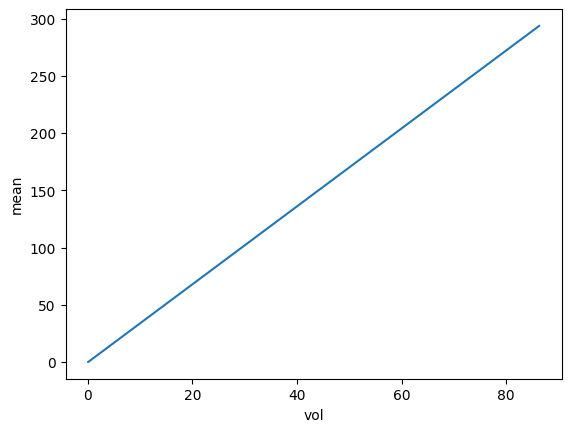

In [91]:
# il me semble que c est de la merde 

plt.plot(mus, vols)
plt.xlabel("vol")
plt.ylabel("mean")